In [2]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [3]:
import biomart
import os
import re
import matplotlib

import pandas as pd
import pickle as pkl
import numpy as np
import collections as cx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from goatools.go_search import GoSearch
from scipy import stats

from src.config import get_hussmann_supplementary_xlsx, HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE, get_interim_dir, get_experiment_artifacts

from sklearn.metrics import PrecisionRecallDisplay, jaccard_score

In [4]:
HOME_PATH, FILTER_COUNT, METHOD, PROFILE_TYPE

('/Users/colm', 700, 'robust_cov', 'paired-replicates')

# Consistency always seems to preform best with 700 reads, sample-wise outlier detection.

Having a small, consistently outlying effect in one feature is more indicative of DSB involvement than big outlying effects which vary widely, which our method would be more sensitive to. How do we capture these consistent effects?

In [5]:
MAX_NUM_OUTLIERS = 500

In [6]:
full_results_df = pd.read_pickle(get_experiment_artifacts() + "/augmented_with_GO_outlier_results.pkl")

full_results_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.321429  -0.487511                -0.922377   
0610010K14Rik -0.506267         0.309524  -0.554160                -0.157728   
0610030E20Rik -0.096154         0.130952  -0.334093                 0.255744   
0610040J01Rik  0.585708         0.107143   0.246902                -0.290237   
1110004F10Rik  0.243536        -0.238095   0.024213                -0.282795   
...                 ...              ...        ...                      ...   
Znhit1         0.521094         0.196429   0.292026                 0.799272   
Zranb2         0.953777         0.142857   0.670830                 0.540839   
Zrsr1          0.251496        -0.250000  -0.017179                -1.230343   
Zup1           0.072598        -0.125000  -0.145972                -0.597271   
Zwilch         0.378405         0.071429   0.058281                -0.721362   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -1.031957       -0.964286   -0.821429   0.169394   
0610010K14Rik             0.498403        0.392857    0.571429   1.420544   
0610030E20Rik             0.081228        0.178571    0.464286   8.092794   
0610040J01Rik             0.013855        0.000000    0.250000  12.609331   
1110004F10Rik            -0.804186        0.107143   -0.071429   9.343101   
...                            ...             ...         ...        ...   
Znhit1                    0.242960             NaN         NaN        NaN   
Zranb2                    0.106162             NaN         NaN        NaN   
Zrsr1                    -0.801873             NaN         NaN        NaN   
Zup1                     -0.514256             NaN         NaN        NaN   
Zwilch                   -0.055045             NaN         NaN        NaN   

Sample                               T2  ...                        T3  \
Measure         pvalues CLR Consistency  ...   pvalues CLR Consistency   
Gene                                     ...                             
0610009B22Rik  0.999409       -0.142857  ...  0.733467        0.250000   
0610010K14Rik  0.922053       -0.142857  ...  0.731721       -0.214286   
0610030E20Rik  0.151195        0.321429  ...  0.684153        0.071429   
0610040J01Rik  0.027328       -0.392857  ...  0.233254        0.285714   
1110004F10Rik  0.096137       -0.071429  ...  0.283318       -0.142857   
...                 ...             ...  ...       ...             ...   
Znhit1              NaN        0.714286  ...  0.019401        0.107143   
Zranb2              NaN        0.142857  ...  0.033617        0.464286   
Zrsr1               NaN       -0.428571  ...  0.400979       -0.464286   
Zup1                NaN       -0.178571  ...  0.116112       -0.178571   
Zwilch              NaN        0.000000  ...  0.372210       -0.464286   

Sample                                         Gene Sets              \
Measure       Consistency  distances   pvalues   Adamson GeneSubset2   
Gene                                                                   
0610009B22Rik   -0.214286   6.205324  0.286750     False       False   
0610010K14Rik    0.535714   2.871384  0.719807     False       False   
0610030E20Rik   -0.214286   3.765686  0.583620     False       False   
0610040J01Rik    0.142857  14.848909  0.011028     False       False   
1110004F10Rik   -0.428571  11.095744  0.049514     False       False   
...                   ...        ...       ...       ...         ...   
Znhit1          -0.500000   9.115033  0.104563      True       False   
Zranb2           0.464286  18.886149  0.002

In [7]:

outliers_df = full_results_df.sort_values(("Global", "Mean Score"), ascending=False).iloc[:500,:]

outliers_df

Sample        Global                                                       \
Measure    Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                        
Atp6v1g1  111.380978         0.285714  64.573446                 0.624881   
Metap2     30.077542         0.696429  21.566442                 1.132285   
H2ac18     33.587241         0.178571  20.234838                 0.626458   
Xrcc5      28.065838         0.803571  19.935575                 1.008587   
H2ax       24.281807         0.880952  19.919822                 1.770593   
...              ...              ...        ...                      ...   
Krtap6-5    4.167767         0.392857   3.282919                 0.608833   
Atp5o       3.614611         0.571429   3.281903                 0.840110   
Psmd12      4.405255         0.196429   3.270553                 0.203096   
Lrr1        3.697573         0.785714   3.266324                 1.345542   
C1d         4.581513         0.452381   3.263987                 0.953380   

Sample                                     T1                          \
Measure  Mean Std Consistency CLR Consistency Consistency   distances   
Gene                                                                    
Atp6v1g1             0.441456             NaN         NaN         NaN   
Metap2               1.400492             NaN         NaN         NaN   
H2ac18               0.193206             NaN         NaN         NaN   
Xrcc5                1.652481             NaN         NaN         NaN   
H2ax                 1.847420        0.714286    0.857143  253.225165   
...                       ...             ...         ...         ...   
Krtap6-5             0.679654        0.535714    0.214286   33.253036   
Atp5o                1.111628             NaN         NaN         NaN   
Psmd12               0.233403             NaN         NaN         NaN   
Lrr1                 1.610206             NaN         NaN         NaN   
C1d                  0.807627        0.071429    0.000000   43.717396   

Sample                              T2  ...                            T3  \
Measure        pvalues CLR Consistency  ...       pvalues CLR Consistency   
Gene                                    ...                                 
Atp6v1g1           NaN        0.142857  ...  0.000000e+00        0.535714   
Metap2             NaN        0.428571  ...  0.000000e+00        0.678571   
H2ac18             NaN        0.285714  ...  1.221245e-15        0.392857   
Xrcc5              NaN        0.642857  ...  0.000000e+00        0.357143   
H2ax      0.000000e+00        0.964286  ...  0.000000e+00        0.785714   
...                ...             ...  ...           ...             ...   
Krtap6-5  3.352149e-06        0.321429  ...  7.535679e-09        0.142857   
Atp5o              NaN        0.607143  ...  1.183151e-08        0.250000   
Psmd12             NaN        0.000000  ...  2.524015e-10        0.321429   
Lrr1               NaN        0.714286  ...  5.027872e-07        0.571429   
C1d       2.643239e-08        0.642857  ...  4.437316e-06        0.750000   

Sample                                          Gene Sets              \
Measure  Consistency    distances       pvalues   Adamson GeneSubset2   
Gene                                                                    
Atp6v1g1    0.428571  1230.127000  0.000000e+00     False       False   
Metap2      0.750000   338.335459  0.000000e+00     False       False   
H2ac18      0.178571   376.832241  0.000000e+00     False       False   
Xrcc5       0.678571   316.269724  0.000000e+00      True        True   
H2ax        0.821429   177.472104  0.000000e+00     False       False   
...              ...          ...           ...       ...         ...   
Krtap6-5    0.464286    54.139376  1.962043e-10     False       False   
Atp5o       0.392857    40.773257  1.042624e-07     False       False   
Psmd12      0.32

In [8]:
print("There are num outliers:", outliers_df.shape[0])

There are num outliers: 500


In [9]:
outliers_df.xs("Consistency", level="Measure", axis=1).stack().reset_index().rename(columns={0: "Consistency"})

,Gene,Sample,Consistency
0,Atp6v1g1,T2,0.142857
1,Atp6v1g1,T3,0.428571
2,Metap2,T2,0.642857
3,Metap2,T3,0.750000
4,H2ac18,T2,0.178571
...,...,...,...
1196,Lrr1,T2,0.857143
1197,Lrr1,T3,0.714286
1198,C1d,T1,0.000000
1199,C1d,T2,0.535714


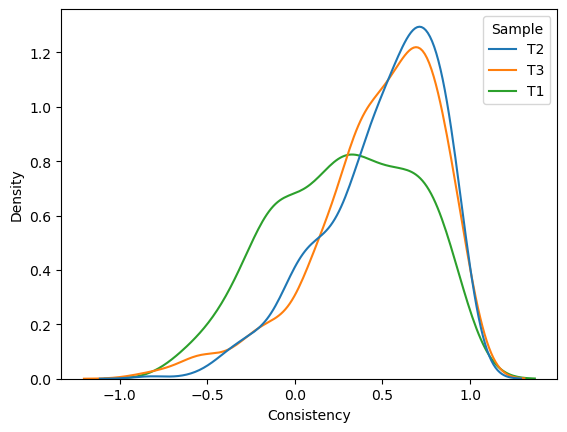

In [10]:
sns.kdeplot(data=outliers_df.xs("Consistency", level="Measure", axis=1).stack().reset_index().rename(columns={0: "Consistency"}), hue="Sample", x="Consistency", common_norm=False)
plt.savefig("{}/consistency_density_plots.png".format(get_experiment_artifacts()))

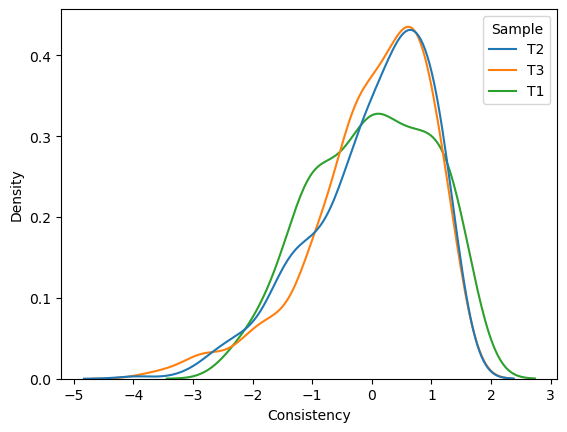

In [11]:
std_outliers_df = pd.DataFrame(StandardScaler().fit_transform(outliers_df.xs("Consistency", level="Measure", axis=1)), columns=["T1", "T2", "T3"])
sns.kdeplot(data=std_outliers_df.stack().reset_index().rename(columns={0: "Consistency", "level_1": "Sample"}), hue="Sample", x="Consistency", common_norm=False)
plt.savefig("{}/consistency_standardised_density_plots.png".format(get_experiment_artifacts()))

In [12]:
outliers_df.shape

(500, 22)

In [13]:
from sklearn import metrics

def plot_curves(outliers_df, genes, limit=None, name=None):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))

    if limit is not None:
        fig.suptitle("PR Curve of top {} genes, ranked...".format(limit))
    else:
        fig.suptitle("PR Curve of all genes, ranked...")

    if limit is None:
        limit = outliers_df.shape[0]

    all_y = np.isin(outliers_df.sample(frac=1).index.to_list(), genes)

    y = all_y[:limit]

    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y)))[::-1],
        name=f"PR Curve",
        color="darkorange",
        ax=ax1
    )
    ax1.legend(loc='upper right')
    ax1.title.set_text("Randomly")
    # ax1.title.set_text("Randomly (Positives: {}/ {})".format(sum(y), sum(all_y)))
    
    # y = np.isin(outliers_df.sort_values(("Global", "Reject")).index.to_list(), genes)[-limit:]
    # display = PrecisionRecallDisplay.from_predictions(
    #     y,
    #     list(range(len(y))),
    #     name=f"PR Curve",
    #     color="darkorange",
    #     ax=ax2
    # )
    # ax2.title.set_text("Num of Samples Rejected (Positives: {}/ {})".format(sum(y), sum(all_y)))

    # print(metrics.average_precision_score(y[-limit:], np.array(range(len(y[-limit:])))/np.max(y[-limit:])))

    # y = np.isin(outliers_df.sort_values(("Global", "Mean Score")).index.to_list(), genes)[-limit:]
    # display = PrecisionRecallDisplay.from_predictions(
    #     y,
    #     list(range(len(y))),
    #     name=f"PR Curve",
    #     color="darkorange",
    #     ax=ax2
    # )
    # ax2.legend(loc='upper right')
    # ax2.title.set_text("Score")
    # ax3.title.set_text("By Mean Score (Positives: {}/ {})".format(sum(y), sum(all_y)))

    # print(metrics.average_precision_score(y[-limit:], np.array(range(len(y[-limit:])))/np.max(y[-limit:])))

    y = np.isin(outliers_df.sort_values(("Global", "Mean Std Consistency")).index.to_list(), genes)[-limit:]
    display = PrecisionRecallDisplay.from_predictions(
        y,
        list(range(len(y))),
        name=f"PR Curve",
        color="darkorange",
        ax=ax2
    )
    ax2.legend(loc='upper right')
    ax2.title.set_text("Consistency")
    # ax3.title.set_text("Mean Std Consistency (Positives: {}/ {})".format(sum(y), sum(all_y)))

    # print(metrics.average_precision_score(y[-limit:], np.array(range(len(y[-limit:])))/np.max(y[-limit:])))

    # y = np.isin(outliers_df.sort_values(("Global", "Max Score")).index.to_list(), genes)[-limit:]
    # display = PrecisionRecallDisplay.from_predictions(
    #     y,
    #     list(range(len(y))),
    #     name=f"PR Curve",
    #     color="darkorange",
    #     ax=ax5
    # )
    # ax5.title.set_text("Max Score (Positives: {}/ {})".format(sum(y), sum(all_y)))

    # print(metrics.average_precision_score(y[-limit:], np.array(range(len(y[-limit:])))/np.max(y[-limit:])))

    plt.tight_layout()
    plt.suptitle(name)
    fig.savefig(get_experiment_artifacts() + "rankingcomparison.{}.{}.pdf".format(name, limit if limit is not None else "all"))
    plt.show()

476


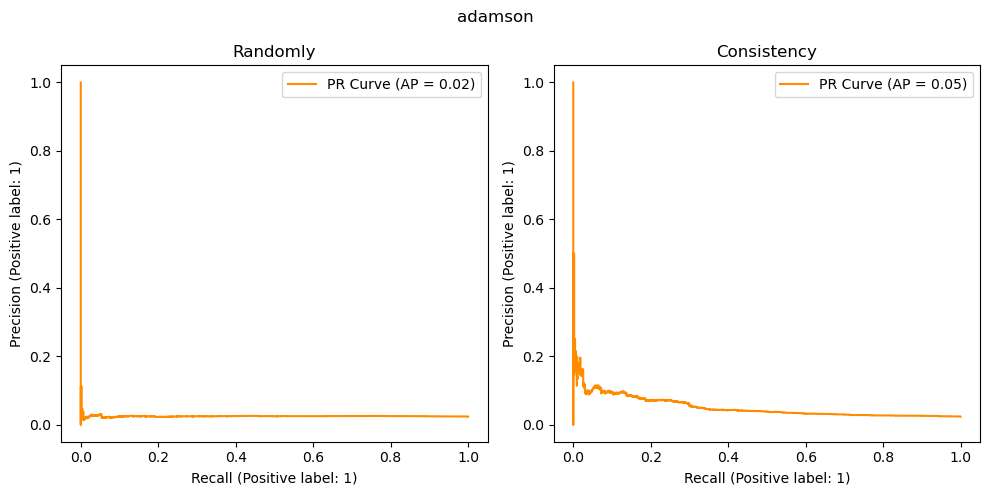

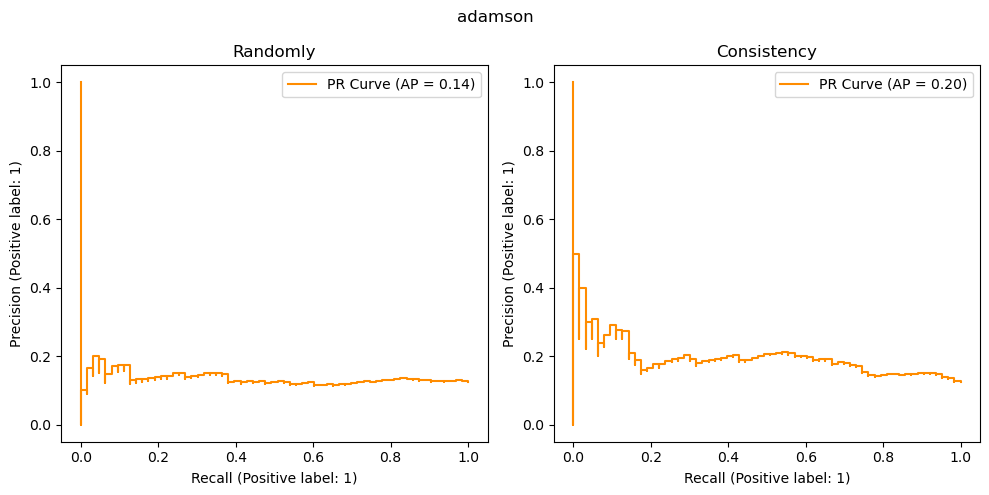

In [14]:
adamson_genes = pd.read_excel(get_hussmann_supplementary_xlsx(4), sheet_name="Table S4", skiprows=1)["Gene"].str.capitalize()
print(len(adamson_genes))
plot_curves(full_results_df, adamson_genes, limit=None, name="adamson")
plot_curves(outliers_df, adamson_genes, limit=MAX_NUM_OUTLIERS, name="adamson")

473


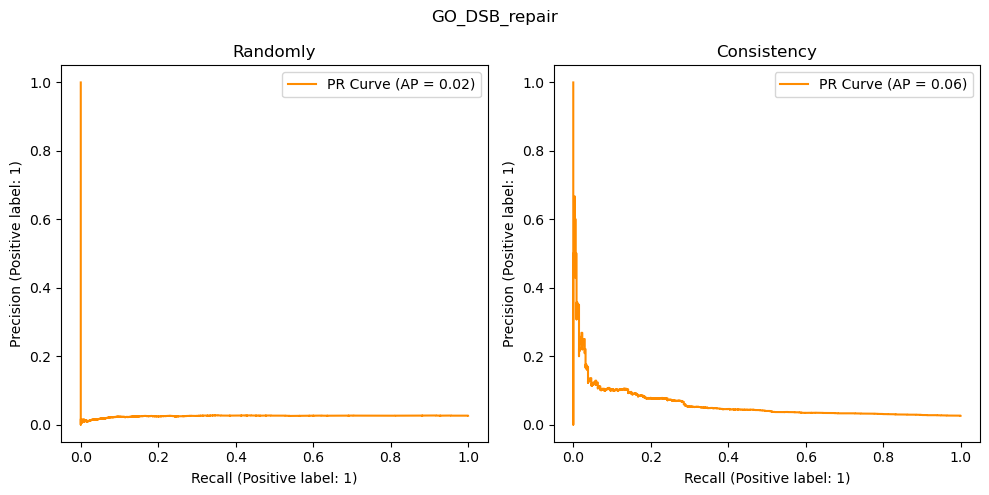

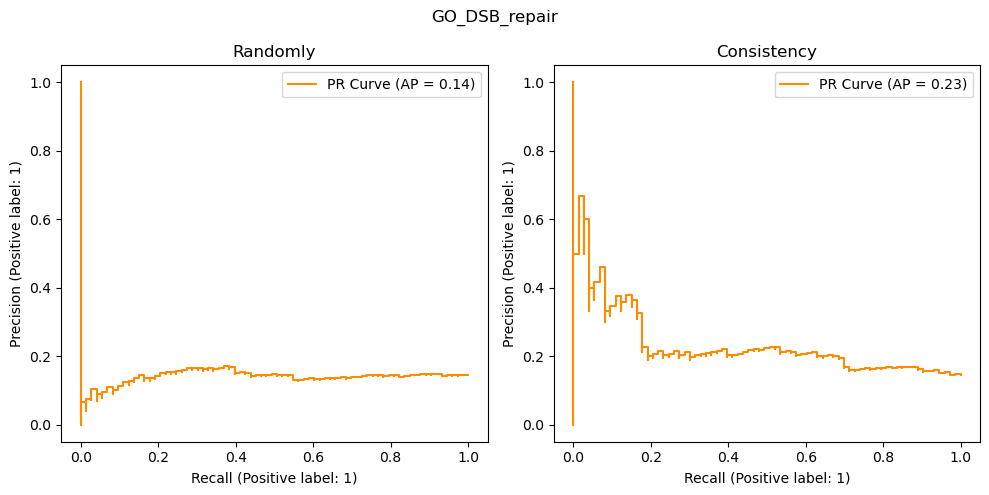

In [15]:
GODSBRepair = full_results_df.loc[full_results_df[("Global", "isGODSBRepair")]].index.to_list()
print(len(GODSBRepair))
plot_curves(full_results_df, GODSBRepair, limit=None, name="GO_DSB_repair")
GODSBRepair = outliers_df.loc[outliers_df[("Global", "isGODSBRepair")]].index.to_list()
plot_curves(outliers_df, GODSBRepair, limit=MAX_NUM_OUTLIERS, name="GO_DSB_repair")

In [16]:
len(GODSBRepair)

73

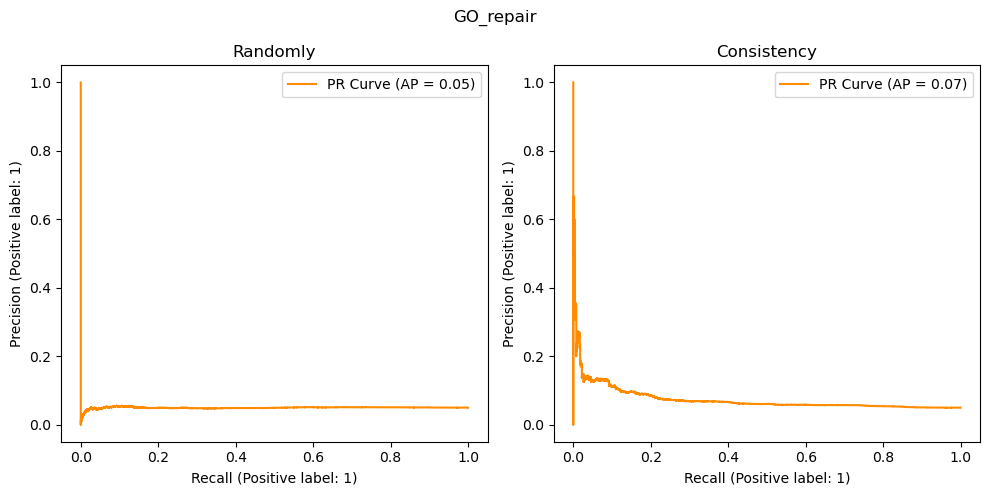

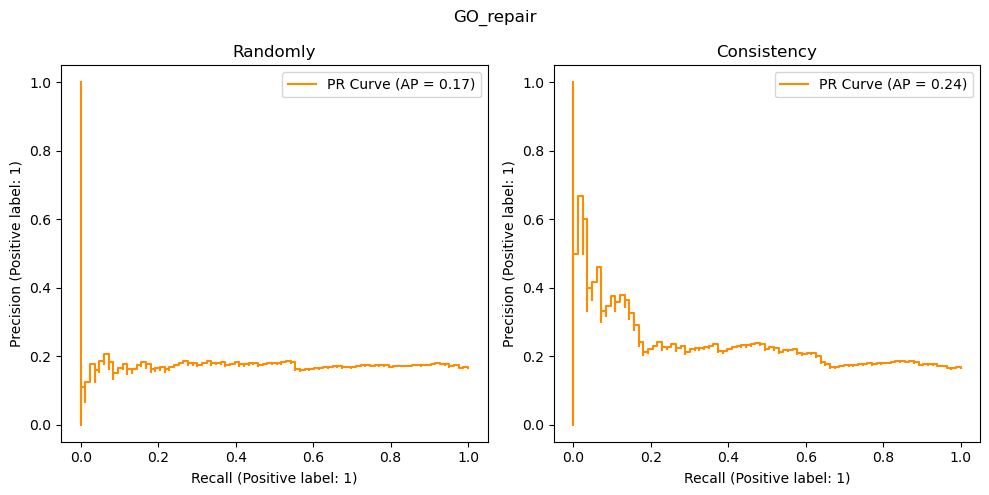

In [17]:
GORepair = full_results_df.loc[full_results_df[("Global", "isGORepair")]].index.to_list()
plot_curves(full_results_df, GORepair, limit=None, name="GO_repair")
GORepair = outliers_df.loc[outliers_df[("Global", "isGORepair")]].index.to_list()
plot_curves(outliers_df, GORepair, limit=MAX_NUM_OUTLIERS, name="GO_repair")

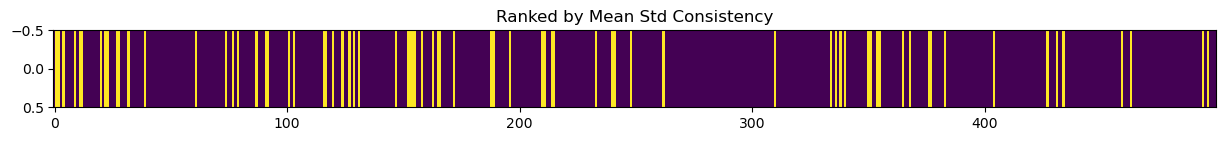

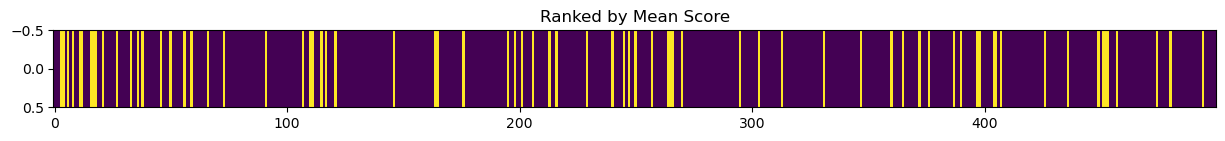

In [18]:
def calculate_identified_repair_genes_jaccard_index(genes, outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=None):
    if limit is None:
        raise Exception("A limit must be set")
    x = np.intersect1d(outliers_df.sort_values(("Global", stat1), ascending=False).index.to_list()[:limit], genes)
    y = np.intersect1d(outliers_df.sort_values(("Global", stat2), ascending=False).index.to_list()[:limit], genes)

    intersection = np.intersect1d(x, y)
    union = np.union1d(x, y)

    # print(intersection)
    # print(union)

    print(intersection.shape[0]/union.shape[0])

def calculate_jaccard_index(outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=None):
    if limit is None:
        raise Exception("A limit must be set")
    x = outliers_df.sort_values(("Global", stat1), ascending=False).index.to_list()[:limit]
    y = outliers_df.sort_values(("Global", stat2), ascending=False).index.to_list()[:limit]

    intersection = np.intersect1d(x, y)
    union = np.union1d(x, y)

    # print(intersection)
    # print(union)

    print(intersection.shape[0]/union.shape[0])
    

# plot_curves(outliers_df, GORepair, limit=MAX_NUM_OUTLIERS, name="GO_repair")
def plot_ranking_vis(genes, outliers_df, stat="Mean Score", limit=None):
    if limit is None:
        limit = outliers_df.shape[0]
    fix, ax = plt.subplots(figsize=(15,1))
    y = np.isin(outliers_df.sort_values(("Global", stat), ascending=False).index.to_list(), genes)[:limit]
    im = ax.imshow(y[np.newaxis,:], interpolation='none', aspect="auto")
    plt.title("Ranked by {}".format(stat))
    plt.show()

plot_ranking_vis(GODSBRepair, outliers_df, stat="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)
plot_ranking_vis(GODSBRepair, outliers_df, stat="Mean Score", limit=MAX_NUM_OUTLIERS)

In [19]:
calculate_identified_repair_genes_jaccard_index(adamson_genes, outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)
calculate_jaccard_index(outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)

1.0
1.0


In [20]:
calculate_identified_repair_genes_jaccard_index(GODSBRepair, outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)
calculate_jaccard_index(outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)

1.0
1.0


In [21]:
calculate_identified_repair_genes_jaccard_index(GORepair, outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)
calculate_jaccard_index(outliers_df, stat1="Mean Score", stat2="Mean Std Consistency", limit=MAX_NUM_OUTLIERS)

1.0
1.0


In [22]:
outliers_df.sort_values(by=("Global", "Mean Score"), ascending=False)

Sample        Global                                                       \
Measure    Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                        
Atp6v1g1  111.380978         0.285714  64.573446                 0.624881   
Metap2     30.077542         0.696429  21.566442                 1.132285   
H2ac18     33.587241         0.178571  20.234838                 0.626458   
Xrcc5      28.065838         0.803571  19.935575                 1.008587   
H2ax       24.281807         0.880952  19.919822                 1.770593   
...              ...              ...        ...                      ...   
Krtap6-5    4.167767         0.392857   3.282919                 0.608833   
Atp5o       3.614611         0.571429   3.281903                 0.840110   
Psmd12      4.405255         0.196429   3.270553                 0.203096   
Lrr1        3.697573         0.785714   3.266324                 1.345542   
C1d         4.581513         0.452381   3.263987                 0.953380   

Sample                                     T1                          \
Measure  Mean Std Consistency CLR Consistency Consistency   distances   
Gene                                                                    
Atp6v1g1             0.441456             NaN         NaN         NaN   
Metap2               1.400492             NaN         NaN         NaN   
H2ac18               0.193206             NaN         NaN         NaN   
Xrcc5                1.652481             NaN         NaN         NaN   
H2ax                 1.847420        0.714286    0.857143  253.225165   
...                       ...             ...         ...         ...   
Krtap6-5             0.679654        0.535714    0.214286   33.253036   
Atp5o                1.111628             NaN         NaN         NaN   
Psmd12               0.233403             NaN         NaN         NaN   
Lrr1                 1.610206             NaN         NaN         NaN   
C1d                  0.807627        0.071429    0.000000   43.717396   

Sample                              T2  ...                            T3  \
Measure        pvalues CLR Consistency  ...       pvalues CLR Consistency   
Gene                                    ...                                 
Atp6v1g1           NaN        0.142857  ...  0.000000e+00        0.535714   
Metap2             NaN        0.428571  ...  0.000000e+00        0.678571   
H2ac18             NaN        0.285714  ...  1.221245e-15        0.392857   
Xrcc5              NaN        0.642857  ...  0.000000e+00        0.357143   
H2ax      0.000000e+00        0.964286  ...  0.000000e+00        0.785714   
...                ...             ...  ...           ...             ...   
Krtap6-5  3.352149e-06        0.321429  ...  7.535679e-09        0.142857   
Atp5o              NaN        0.607143  ...  1.183151e-08        0.250000   
Psmd12             NaN        0.000000  ...  2.524015e-10        0.321429   
Lrr1               NaN        0.714286  ...  5.027872e-07        0.571429   
C1d       2.643239e-08        0.642857  ...  4.437316e-06        0.750000   

Sample                                          Gene Sets              \
Measure  Consistency    distances       pvalues   Adamson GeneSubset2   
Gene                                                                    
Atp6v1g1    0.428571  1230.127000  0.000000e+00     False       False   
Metap2      0.750000   338.335459  0.000000e+00     False       False   
H2ac18      0.178571   376.832241  0.000000e+00     False       False   
Xrcc5       0.678571   316.269724  0.000000e+00      True        True   
H2ax        0.821429   177.472104  0.000000e+00     False       False   
...              ...          ...           ...       ...         ...   
Krtap6-5    0.464286    54.139376  1.962043e-10     False       False   
Atp5o       0.392857    40.773257  1.042624e-07     False       False   
Psmd12      0.32

In [23]:
full_results_df

Sample           Global                                                       \
Measure       Max Score Mean Consistency Mean Score Mean Std CLR Consistency   
Gene                                                                           
0610009B22Rik -0.202316        -0.321429  -0.487511                -0.922377   
0610010K14Rik -0.506267         0.309524  -0.554160                -0.157728   
0610030E20Rik -0.096154         0.130952  -0.334093                 0.255744   
0610040J01Rik  0.585708         0.107143   0.246902                -0.290237   
1110004F10Rik  0.243536        -0.238095   0.024213                -0.282795   
...                 ...              ...        ...                      ...   
Znhit1         0.521094         0.196429   0.292026                 0.799272   
Zranb2         0.953777         0.142857   0.670830                 0.540839   
Zrsr1          0.251496        -0.250000  -0.017179                -1.230343   
Zup1           0.072598        -0.125000  -0.145972                -0.597271   
Zwilch         0.378405         0.071429   0.058281                -0.721362   

Sample                                          T1                         \
Measure       Mean Std Consistency CLR Consistency Consistency  distances   
Gene                                                                        
0610009B22Rik            -1.031957       -0.964286   -0.821429   0.169394   
0610010K14Rik             0.498403        0.392857    0.571429   1.420544   
0610030E20Rik             0.081228        0.178571    0.464286   8.092794   
0610040J01Rik             0.013855        0.000000    0.250000  12.609331   
1110004F10Rik            -0.804186        0.107143   -0.071429   9.343101   
...                            ...             ...         ...        ...   
Znhit1                    0.242960             NaN         NaN        NaN   
Zranb2                    0.106162             NaN         NaN        NaN   
Zrsr1                    -0.801873             NaN         NaN        NaN   
Zup1                     -0.514256             NaN         NaN        NaN   
Zwilch                   -0.055045             NaN         NaN        NaN   

Sample                               T2  ...                        T3  \
Measure         pvalues CLR Consistency  ...   pvalues CLR Consistency   
Gene                                     ...                             
0610009B22Rik  0.999409       -0.142857  ...  0.733467        0.250000   
0610010K14Rik  0.922053       -0.142857  ...  0.731721       -0.214286   
0610030E20Rik  0.151195        0.321429  ...  0.684153        0.071429   
0610040J01Rik  0.027328       -0.392857  ...  0.233254        0.285714   
1110004F10Rik  0.096137       -0.071429  ...  0.283318       -0.142857   
...                 ...             ...  ...       ...             ...   
Znhit1              NaN        0.714286  ...  0.019401        0.107143   
Zranb2              NaN        0.142857  ...  0.033617        0.464286   
Zrsr1               NaN       -0.428571  ...  0.400979       -0.464286   
Zup1                NaN       -0.178571  ...  0.116112       -0.178571   
Zwilch              NaN        0.000000  ...  0.372210       -0.464286   

Sample                                         Gene Sets              \
Measure       Consistency  distances   pvalues   Adamson GeneSubset2   
Gene                                                                   
0610009B22Rik   -0.214286   6.205324  0.286750     False       False   
0610010K14Rik    0.535714   2.871384  0.719807     False       False   
0610030E20Rik   -0.214286   3.765686  0.583620     False       False   
0610040J01Rik    0.142857  14.848909  0.011028     False       False   
1110004F10Rik   -0.428571  11.095744  0.049514     False       False   
...                   ...        ...       ...       ...         ...   
Znhit1          -0.500000   9.115033  0.104563      True       False   
Zranb2           0.464286  18.886149  0.002

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.026e-02 t=-2.317e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:4.221e-19 t=-8.864e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: t-test independent samples, P_val:1.406e-09 t=-5.945e+00


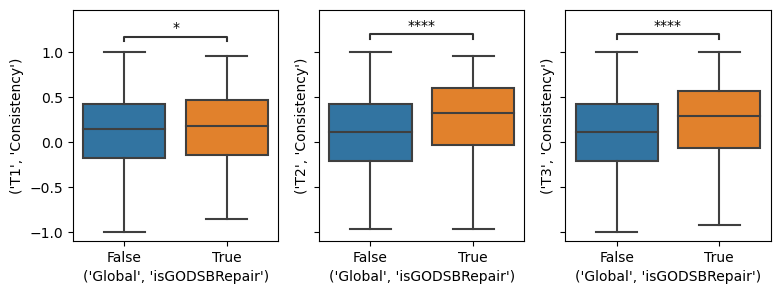

In [63]:
from statannotations.Annotator import Annotator

fig = plt.figure(figsize=(9, 3))
ax = fig.subplots(1, 3, sharey=True)

for i, t in enumerate(["T1", "T2", "T3"]):
    sns.boxplot(data=full_results_df, y=(t, "Consistency"), x=("Global", "isGODSBRepair"), ax=ax[i])

    pairs=[(False, True)]
    annotator = Annotator(ax[i], pairs, data=full_results_df, y=(t, "Consistency"), x=("Global", "isGODSBRepair"))
    annotator.configure(test='t-test_ind', text_format='star', loc='inside')
    annotator.apply_test(alternative="less")
    annotator.annotate()
plt.show()

